# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

## Importing Libraries and Data

In [1]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [2]:
# Names for accessing SQL database
# Ideally move these to environment variables.

dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

In [3]:
# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Import Analysis Dataset
sql_query = """SELECT * FROM analysis_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

In [4]:
# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['has_rating'], axis=1)
analysis_dt = analysis_dt.drop(['rating'], axis = 1)
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['months_active'], axis = 1)

## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Remove extreme outliers
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [5]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [6]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
# Getting Baseline
baseline_preds = y_train.mean()

# Baseline Errors
baseline_errors = abs(baseline_preds - y)

# Baseline:
print('Mean Absolute Error (naive average): ', round(np.mean(baseline_errors), 2))

Mean Absolute Error (naive average):  19.12


In [73]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt"], "n_estimators": [
    100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 2000]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_squared_error",
                   refit=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
rfr_model = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  2.6min finished


-890.95 {'max_features': 'sqrt', 'n_estimators': 1700}


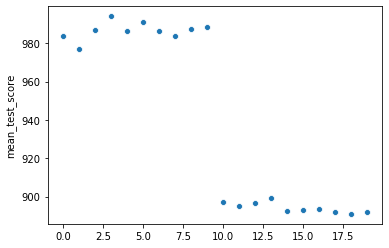

In [74]:
# Plotting Grid Search CV Results
# Saving results to pandas data frame
grid_search_results = pd.DataFrame(clf.cv_results_)

# Plotting
sns.scatterplot(x=list(grid_search_results.index), 
               y=grid_search_results.mean_test_score*-1)

In [75]:
# Predict
preds = rfr_model.predict(X_train)

In [78]:
# Calculate absolute error (comparison with baseline)
errors = abs(preds - y_train)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, preds))

# The coefficient of determination (R2)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, preds))

# Does much better than the mean with regard to mean absolute error
print("A ", round((np.mean(errors)-19.12)/19.12,3)*-100,
      "percent improvement over the mean")

Mean Absolute Error: 7.22
Mean squared error: 133.93
Coefficient of determination: 0.85
A  62.2 percent improvement over the mean


## Fitting AdaBoost Model
The reason to fit this model is that iteratively re-weights observations based on how poorly the model predicts them. This pushes the model to finding a way to predict observations other models may miss. I am concerned, however, if it will overfit to outliers.

It performs poorly compared to the random forest regression.

In [106]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
adaboost_model = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    5.0s


-0.09 {'base_estimator__max_depth': 7, 'n_estimators': 10}


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   17.1s finished


In [107]:
# Predict
preds_ada = adaboost_model.predict(X_train)

In [108]:
# Calculate absolute error (comparison with baseline)
errors = abs(preds_ada - y_train)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_train, preds_ada))

# The coefficient of determination (R2)
print('Coefficient of determination: %.2f'
      % r2_score(y_train, preds_ada))

# Does much better than the mean with regard to mean absolute error
print("A ", round((np.mean(errors)-19.12)/19.12,2)*-100,
      "percent improvement over the mean")

Mean Absolute Error: 14.59
Mean squared error: 334.79
Coefficient of determination: 0.62
A  24.0 percent improvement over the mean


## Exporting Model

Putting the random forest regression model (tuned) into production.

In [72]:
# Saving model with pickle
filename = '/Users/Metaverse/Desktop/Insight/projects/myrate/scripts/finalized_model.sav'
pickle.dump(rfr_model, open(filename, 'wb'))

## Building K-Modes Model to Cluster Users
This is an experimental section. I want to try and create clusters to then provide a range of values ones hourly rate may take. However, the problem with clustering methods (as always) is that it is more of an art than actual science for determining when to stop. I don't think there are very clear clusters in this data. I may be better off running word2vec on the bios (large text) and clustering off that.

In [7]:
# Found K-Modes on stackoverflow
# Following the package documentation
# Ref: https://pypi.org/project/kmodes/
# Ref: https://stackoverflow.com/questions/42639824/python-k-modes-explanation
# Ref: https://www.kaggle.com/ashydv/bank-customer-clustering-k-modes-clustering

In [13]:
# Modeling with K Modes
cost = []
for num_clusters in list(range(1, 21)):
    kmode = KModes(n_clusters=num_clusters, init="Huang", verbose=0, random_state=42)
    kmode.fit_predict(X)
    cost.append(kmode.cost_)
    print("Finished Cluster: " + str(num_clusters))

Finished Cluster: 1
Finished Cluster: 2
Finished Cluster: 3
Finished Cluster: 4
Finished Cluster: 5
Finished Cluster: 6
Finished Cluster: 7
Finished Cluster: 8
Finished Cluster: 9
Finished Cluster: 10
Finished Cluster: 11
Finished Cluster: 12
Finished Cluster: 13
Finished Cluster: 14
Finished Cluster: 15
Finished Cluster: 16
Finished Cluster: 17
Finished Cluster: 18
Finished Cluster: 19
Finished Cluster: 20


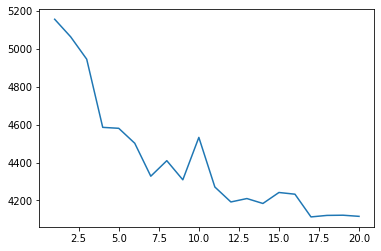

In [12]:
# Plotting cost function result vs number of clusters
number_of_clusters = np.array([i for i in range(1, 21, 1)])
plt.plot(number_of_clusters, cost)

In [17]:
kmode = KModes(n_clusters=6, init='Huang', verbose=0)
clusters = kmode.fit_predict(X)

kmodes = kmode.cluster_centroids_
shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i, :]) == 0:
        print("\ncluster " + str(i) + ": ")
        print("no-skills cluster")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i, :]
        for j in analysis_dt.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
num_skills
bio_length
bio_word_count
avg_word_length
design & art

cluster 1: 
num_skills
bio_length
bio_word_count
avg_word_length
writing & translation

cluster 2: 
num_skills
bio_length
bio_word_count
avg_word_length
business & finance

cluster 3: 
num_skills
bio_length
bio_word_count
avg_word_length
num_stop
sales & marketing

cluster 4: 
num_skills
bio_length
bio_word_count
avg_word_length
administrative & secretarial

cluster 5: 
num_skills
bio_length
bio_word_count
avg_word_length
num_stop
programming & development


In [22]:
clust_assigned = kmode.predict(X)

In [23]:
unique, counts = np.unique(clust_assigned, return_counts=True)
dict(zip(unique, counts))

{0: 294, 1: 285, 2: 91, 3: 123, 4: 38, 5: 80}

In [35]:
analysis_dt['cluster'] = list(clust_assigned)

In [40]:
analysis_dt[analysis_dt.cluster == 0]

,index,rating,hourly_rate,has_rating,months_active,num_skills,bio_length,bio_word_count,avg_word_length,num_stop,...,administrative & secretarial,business & finance,design & art,education & training,engineering & architecture,legal,programming & development,sales & marketing,writing & translation,cluster
4,5,100.0,50,1,7.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,1,0,0,0
6,7,100.0,40,1,6.0,5,1081,158,6.600000,25,...,0,0,0,0,1,0,0,0,0,0
7,8,91.7,20,1,6.0,5,2,1,2.000000,0,...,0,0,1,0,0,0,0,0,0,0
8,9,100.0,30,1,4.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
14,15,100.0,50,1,27.0,5,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,955,100.0,15,1,6.0,2,2,1,2.000000,0,...,0,0,0,0,0,0,0,1,0,0
903,958,100.0,10,1,61.0,5,564,91,5.208791,39,...,0,0,1,0,0,0,0,0,0,0
904,959,100.0,5,1,13.0,4,478,86,4.623529,37,...,0,0,1,0,0,0,0,0,0,0
905,960,100.0,15,1,97.0,5,385,76,4.366197,29,...,0,0,1,0,0,0,0,0,1,0
